In [1]:
%matplotlib inline
import os
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
DATASET_ROOT = './0608'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'tasharep.csv')
TS_IN=20
TS_OUT=5
fields = ['代碼', '開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,1101,20130102,台泥,30.41,30.53,30.18,30.45,6374.0
1332,1102,20130102,亞泥,28.74,28.90,28.70,28.78,2856.0
2664,1103,20130102,嘉泥,12.29,12.33,12.24,12.24,315.0
3996,1104,20130102,環泥,11.87,12.17,11.87,12.06,551.0
5328,1108,20130102,幸福,5.18,5.22,5.16,5.18,447.0
6660,1109,20130102,信大,9.24,9.28,9.19,9.24,104.0
7992,1110,20130102,東泥,13.41,13.46,13.23,13.23,169.0
9324,1201,20130102,味全,35.69,37.74,35.44,37.69,8971.0
10656,1203,20130102,味王,16.61,16.78,16.61,16.73,143.0
11988,1210,20130102,大成,16.84,16.99,16.84,16.87,1373.0


In [4]:
codes = list(sorted(set(train_csv['代碼'])))
days  = list(sorted(set(train_csv['日期'])))
print(len(days))

1332


In [5]:
split_data = [] # 同一天分配在同一 row (已對時間排序)
for day in days:
    row = train_csv.loc[train_csv['日期']==day][fields]
    split_data.append(row)

In [6]:
subset = set(codes)
print(len(subset))
for n, s in enumerate(split_data):
    subset = subset & set(s['代碼']) # 尋找每天股票種類的交集
# subset = list(sorted(list(subset)))
# display(subset) # 從以前到現在每一天都存在的股票們
print(len(subset))

1691
1387


In [7]:
np.save('codes_subset.npy', np.asarray(list(sorted(list(subset))))) # 將 code 的交集存起來，以後用得到

In [8]:
print(len(split_data))
for n in reversed(range(len(split_data))):
    mask = split_data[n]['代碼'].isin(subset) # 濾除不在交集內的股票
    split_data[n] = split_data[n].loc[mask]
    assert len(split_data[n])==len(subset), '若濾除後，同一天股票數量與我們想要的股票集和大小不同的話，那一定有錯誤發生' # 若濾除後，同一天股票數量與我們想要的股票集和大小不同的話，那一定有錯誤發生
print(len(split_data))
display(split_data[0].head(n=10))

1332
1332


,代碼,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,1101,30.41,30.53,30.18,30.45,6374.0
1332,1102,28.74,28.90,28.70,28.78,2856.0
2664,1103,12.29,12.33,12.24,12.24,315.0
3996,1104,11.87,12.17,11.87,12.06,551.0
5328,1108,5.18,5.22,5.16,5.18,447.0
6660,1109,9.24,9.28,9.19,9.24,104.0
7992,1110,13.41,13.46,13.23,13.23,169.0
9324,1201,35.69,37.74,35.44,37.69,8971.0
10656,1203,16.61,16.78,16.61,16.73,143.0
11988,1210,16.84,16.99,16.84,16.87,1373.0


In [9]:
for n in range(len(split_data)):
    split_data[n] = np.asarray(split_data[n], dtype=np.float32)[...,1:] # drop codes
split_data = np.asarray(split_data, dtype=np.float32)
print(split_data.shape) # shape: (天數, unique 且通常存在股票數, features)

(1332, 1387, 5)


In [10]:
# 看起來都沒問題? 接下來把最後兩個維度壓成同一為，做成 1388*5 維的 featrue 
# 接下來就可以執行 pca 來降維
split_data = split_data.reshape(split_data.shape[0], -1)
print(split_data.shape)# shape: (天數, unique 且通常存在股票數*features)

(1332, 6935)


In [11]:
oops = np.sum(np.isinf(split_data)) # 確認資料乾淨
print('nans: {:d}'.format(int(oops)))
if oops>0:
    split_data = np.nan_to_num(split_data) # 轉換髒掉的資料

nans: 0


In [12]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE, MDS

def plot_embedding(x_emb,title=''):
    ax = plt.subplot()
    ax.scatter(x_emb[:,0], x_emb[:,1])
    ax.set_title(title)
    plt.show()

Wall time: 4.34 s
Wall time: 219 ms
Wall time: 1.58 s
Wall time: 3.99 s
Wall time: 49.2 s


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Wall time: 49.9 s


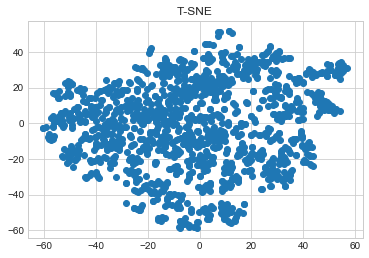

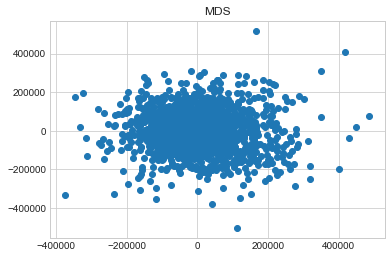

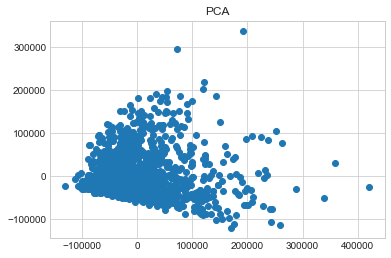

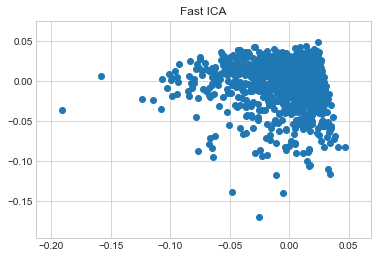

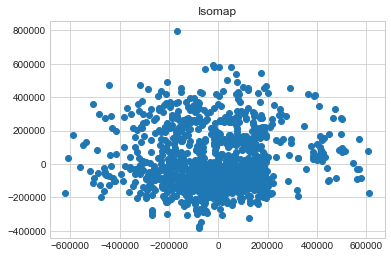

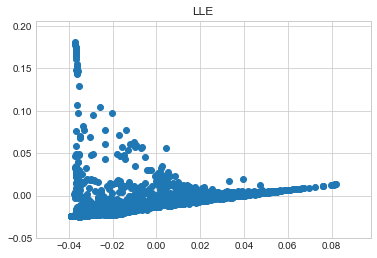

In [13]:
isomap = Isomap(n_neighbors=5, n_components=2, n_jobs=-1)
pca = PCA(n_components=2)
fast_ica = FastICA(n_components=2)
lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2, n_jobs=-1)
mds = MDS(n_components=2, n_jobs=-1)
tsne = TSNE(n_components=2)
%time isomap.fit(split_data)
%time pca.fit(split_data)
%time fast_ica.fit(split_data)
%time lle.fit(split_data)
%time dummy1 = tsne.fit_transform(split_data)
%time dummy2 = mds.fit_transform(split_data)

plot_embedding(dummy1, 'T-SNE')
plot_embedding(dummy2, 'MDS')
del dummy1, dummy2
plot_embedding(pca.transform(split_data), 'PCA')
plot_embedding(fast_ica.transform(split_data), 'Fast ICA')
plot_embedding(isomap.transform(split_data), 'Isomap')
plot_embedding(lle.transform(split_data), 'LLE')


In [14]:
import pickle
isomap = Isomap(n_neighbors=5, n_components=122, n_jobs=-1)
%time isomap.fit(split_data)
with open('isomap.pickle', 'wb') as fp:
    pickle.dump(isomap, fp)

Wall time: 4.83 s


![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

### Todo:
1. 是否需要針對 outlier 做處理 (資料清理)